<a href="https://colab.research.google.com/github/ADutta007/Firstapp/blob/master/dutta_ashish_Assignment_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
apt-get install libgdal-dev -y
apt-get install python-gdal -y
apt-get install python-numpy python-scipy -y

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls
import os
os.getcwd()

drive  IP_Bands.png  IP_GT.png	sample_data


'/content'

In [4]:
import gdal
import matplotlib.pyplot as plt
import numpy as np
import ogr
import pandas as pd

from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
import gdal
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

Import Hyperspectral data

In [5]:
image = gdal.Open('/content/drive/MyDrive/q4_ml/10_4231_R7RX991C/aviris_hyperspectral_data/19920612_AVIRIS_IndianPine_Site3.tif')

Import Ground Reference Data


In [6]:
image_gr = gdal.Open('/content/drive/MyDrive/q4_ml/10_4231_R7RX991C/documentation/Site3_Project_and_Ground_Reference_Files/19920612_AVIRIS_IndianPine_Site3_gr.tif')

Read hyperspectral data

In [8]:
pixels = image.ReadAsArray()
print(pixels.shape)

(220, 145, 145)


In [9]:
pixels_gr = image_gr.ReadAsArray()
print(pixels_gr.shape)

(145, 145)


Plot Ground Reference Data of 16 classes

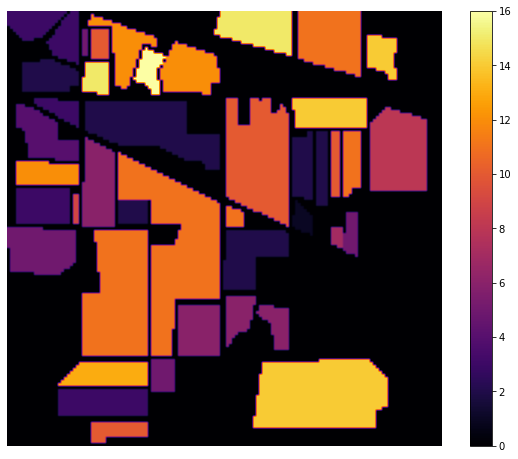

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(pixels_gr, cmap='inferno')
plt.colorbar()
plt.axis('off')
plt.savefig('Ground_Reference.png')
plt.show()

Reshaping Image data into row * column

In [12]:
nb,nr,nc = pixels.shape
row_value = pixels.transpose(1,2,0).reshape(nr*nc,nb)
row_value.shape

(21025, 220)

Loading Class Data

In [13]:
class_data=pd.read_csv('/content/drive/MyDrive/q4_ml/10_4231_R7RX991C/documentation/Site3_Project_and_Ground_Reference_Files/19920612_AVIRIS_IndianPine_Site3_gr_clr.csv')
class_data.head()

,Class,B,G,R,Class_Name
0,0,255,255,255,Background
1,1,255,254,137,Alfalfa
2,2,3,28,241,Corn-notill
3,3,255,89,1,Corn-min
4,4,5,255,133,Corn


Storing column names for each band column

In [14]:
colnames=[]
for i in range(1,pixels.shape[0]+1):
  colnames.append(f'band{i}')



Creating a table to store bands data and class data in a csv format  

In [15]:
df = pd.DataFrame(data = row_value)
df = pd.concat([df, pd.DataFrame(data = pixels_gr.ravel())], axis=1)
df.columns = colnames + ['class']
df['class']=df['class'].map(class_data['Class_Name'])
df.to_csv('hyperspectral_data.csv')
df


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,band201,band202,band203,band204,band205,band206,band207,band208,band209,band210,band211,band212,band213,band214,band215,band216,band217,band218,band219,band220,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4365,4318,4252,4869,5284,5055,3591,...,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,1005,Corn-min
1,3348,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,1000,Corn-min
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,1009,Corn-min
3,3517,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,1005,Corn-min
4,3514,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,1019,Corn-min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,3329,3987,4011,4023,4201,4377,4418,4248,4180,3838,3762,3696,3597,3750,3806,3764,3655,3379,3199,3036,2978,2837,2758,2650,2617,2494,2397,2366,2313,2198,2464,2261,2490,3124,3643,4349,5748,6973,7199,5067,...,1079,1077,1086,1071,1084,1079,1076,1082,1077,1082,1078,1077,1068,1070,1053,1063,1055,1052,1047,1042,1043,1031,1025,1034,1029,1026,1025,1018,1021,1013,1012,1018,1015,1011,1001,1000,1009,1008,1009,Background
21021,3494,4104,4024,3880,4210,4377,4413,4174,4229,3900,3786,3696,3623,3726,3758,3725,3614,3352,3174,3042,2958,2837,2769,2626,2617,2484,2387,2362,2322,2199,2463,2188,2444,3077,3576,4239,5706,6965,7227,5108,...,1076,1086,1081,1069,1086,1078,1081,1078,1075,1084,1087,1082,1071,1064,1059,1063,1051,1049,1042,1042,1043,1031,1029,1029,1026,1021,1026,1021,1023,1012,1014,1012,1024,998,1010,1006,1000,1000,1004,Background
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,3890,3683,3597,3714,3724,3700,3577,3332,3177,3031,2925,2837,2719,2605,2603,2476,2373,2335,2308,2198,2449,2164,2443,3048,3585,4264,5689,6839,7

Plotting cumulative explained variance to check the variance of number of bands that covers whole feature space. 

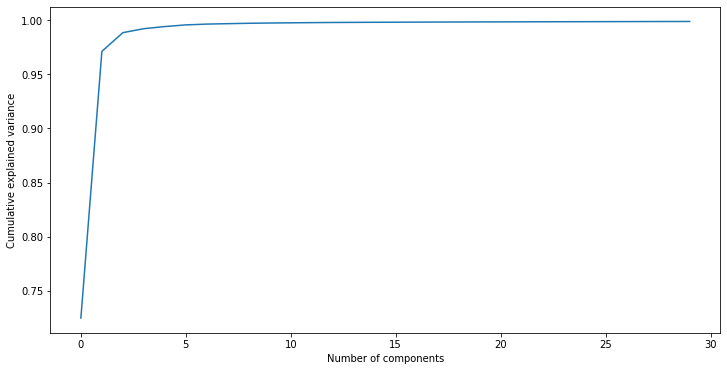

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


PCA tranformation is used for feature space reduction of hyperspectral data. 20 bands are taken as component for PCA and higher ordered principal components are ignored.

In [17]:
pca = PCA(n_components = 20)
dt = pca.fit_transform(df.iloc[:, :-1].values)
#label= df['class']
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = pixels_gr.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,21)]+['class']
q['class']=q['class'].map(class_data['Class_Name'])

In [27]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,PC-16,PC-17,PC-18,PC-19,PC-20,class
0,4815.623760,1669.133437,112.562264,-226.024227,-52.779568,-84.974139,229.299837,69.401608,23.714402,77.244746,-68.435022,151.862472,42.551093,-6.062597,-116.216257,-42.897391,-61.453971,-19.757175,28.142187,-9.380531,Corn-min
1,5338.893731,-1892.484350,540.735016,-179.675640,136.063395,-169.949911,94.494190,14.128248,5.857850,-7.476725,22.397865,59.628348,43.385877,-117.520849,-84.859372,-43.053653,1.957538,-35.909593,16.246056,38.764110,Corn-min
2,5530.420019,-2971.109853,603.055291,-174.276084,73.575274,-124.225567,-194.726258,72.184773,-33.078217,-151.799766,63.253585,100.267351,29.372796,-7.780032,-124.332236,0.290784,93.402728,-14.253043,14.303231,82.425717,Corn-min
3,5324.553566,-2245.995653,550.331614,-175.131843,73.214803,-18.351271,-20.370909,74.547264,-15.527946,7.762413,-48.168848,97.060511,-1.959675,-29.035367,-86.845326,-16.305133,78.202467,-36.259317,23.684141,27.720402,Corn-min
4,4763.780147,454.323928,92.985189,-179.776334,-82.170140,61.531775,-69.275046,217.284255,-47.142044,205.937688,-67.224557,64.979861,-35.901558,9.182390,-128.980886,-12.997394,70.164275,0.194944,-24.519106,50.924372,Corn-min


Plotting the PCA bands

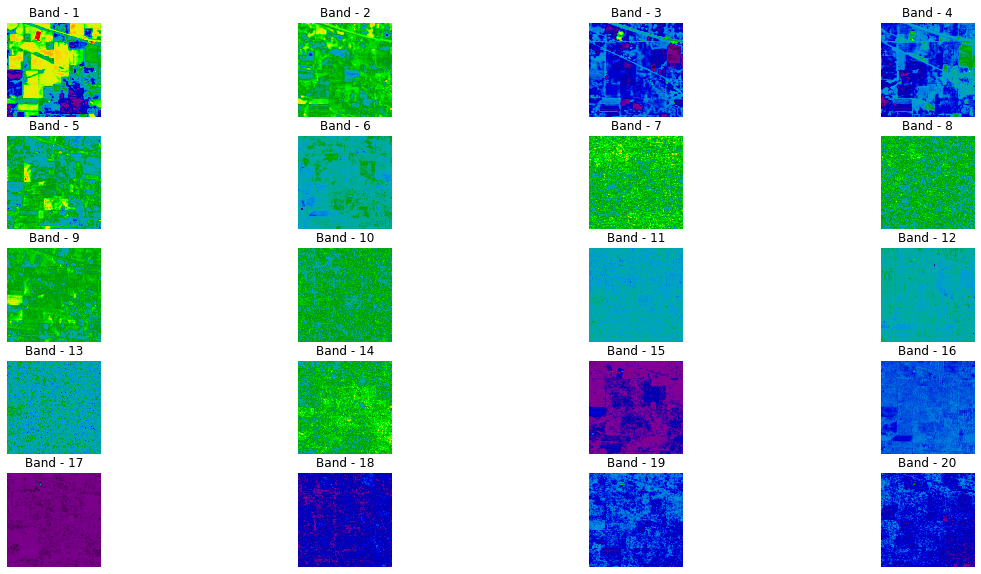

In [18]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 21):
    fig.add_subplot(5,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('PCA_Bands.png')

Data is split to training and testing samples. Support vector regression model is used for training the sample data and hyperparameters are set.

In [21]:
x = q[q['class'] != 'Background']

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 


x_t, x_v, y_t, y_v = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

svm.fit(x_t, y_t)

svm_pred = svm.predict(x_v)

Normalized confusion matrix is generated by tabulating the predicted class names and original class names. 

In [ ]:
all_classes= x['class'].unique()
cm = normalize(confusion_matrix(
    y_v, svm_pred,
    labels = all_classes
))
cm

Accuracy statistics of confusion matrix

In [33]:
class_ii = cm.diagonal()
user = np.zeros(class_ii.shape)
user[class_ii!=0] = class_ii[class_ii!=0]/cm[:, class_ii!=0].sum(axis=0)
prod = np.zeros(class_ii.shape)
prod[class_ii!=0] = class_ii[class_ii!=0]/cm[class_ii!=0, :].sum(axis=1)

print(pd.DataFrame(
    data={'class':all_classes.tolist(), 
          'User': user,
          'Prod': prod
         }))
print('Overall = {}'.format(class_ii.sum()/cm.sum()))

                     class      User      Prod
0                 Corn-min  0.901581  0.844311
1   Bldg-Grass-Tree-Drives  0.719830  0.789474
2             Soybeans-min  0.715370  0.933198
3            Soybean-clean  0.914354  0.902439
4            Grass/Pasture  0.954644  0.959596
5          Soybeans-notill  0.923726  0.865979
6                    Woods  0.825327  0.980695
7       Stone-steel towers  1.000000  1.000000
8              Corn-notill  0.894944  0.822300
9                     Corn  0.958101  0.914894
10           Hay-windrowed  1.000000  0.969388
11             Grass/Trees  0.974531  0.979866
12                    Oats  1.000000  0.750000
13                 Alfalfa  0.969403  1.000000
14     Grass/pasture-mowed  1.000000  1.000000
15                   Wheat  1.000000  0.976190
Overall = 0.911764557318477


Plotting the normalized confusion matrix

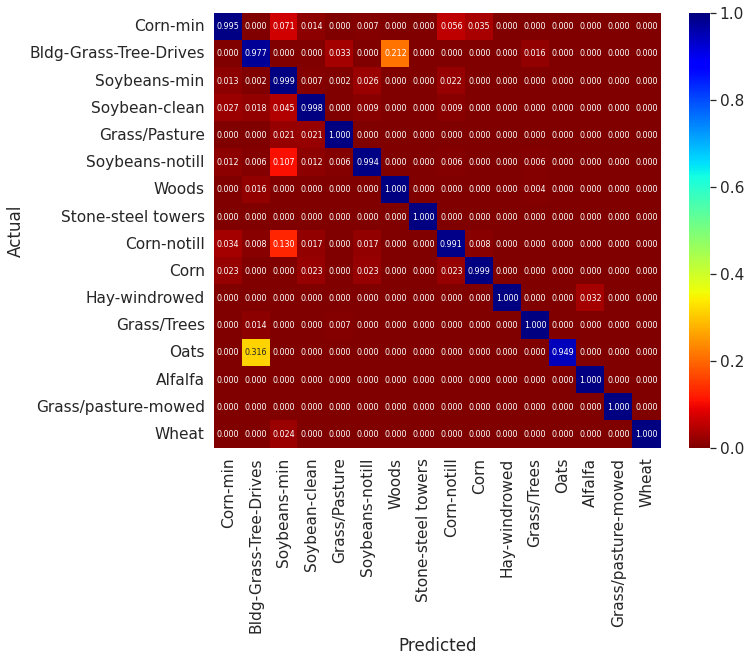

In [47]:
df_cm = pd.DataFrame(cm, columns= all_classes, index = all_classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="jet_r", annot=True,annot_kws={"size": 8}, fmt='.3f')
plt.savefig('normalized_confusion_matrix.png', dpi=300)